<a href="https://colab.research.google.com/github/aaaksenova/NN_methods/blob/change/NLP_hometask_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание метрики по тексту

In [32]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
%matplotlib inline
%pylab inline
import seaborn as sns
import spacy
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Анализ данных

1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) 1 балл

In [33]:
df = pd.read_csv('Shoes_Data.csv') # Загружаем датасет
df

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
...,...,...,...,...,...,...,...,...
1225,Nike Men's React Vision Running Shoes,₹7256.00,4.4 out of 5 stars,200 ratings,The Nike react vision is a STORY of surreal co...,Must buy|| not have a great fiting but great q...,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Women
1226,Puma Men's B.O.G Limitless Hi Evoknit Sneakers,₹5822.00,4.3 out of 5 stars,25 ratings,The B.O.G limitless is Puma's key style for th...,Worth buying !|| Classy Bold and Stylish !!|| ...,4.0 out of 5 stars|| 5.0 out of 5 stars|| 3.0 ...,Women
1227,new balance Women's FuelCell Echolucent Runnin...,₹5362.00,4.5 out of 5 stars,817 ratings,Lead the pack in New Balance’s Echolucent snea...,size variation in product recd n size chart|| ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Women
1228,Nike Women's WMNS Air Zoom Pegasus 37 Running ...,₹7480.00,4.5 out of 5 stars,67 ratings,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,Verified Purchase|| Verified Purchase|| Verifi...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 ...,Women


In [34]:
df.drop_duplicates(inplace=True)  # Удаляем дубликаты
df

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
...,...,...,...,...,...,...,...,...
1193,Nike Men's React Vision Running Shoes,₹7256.00,4.4 out of 5 stars,200 ratings,The Nike react vision is a STORY of surreal co...,Must buy|| not have a great fiting but great q...,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Women
1194,Puma Men's B.O.G Limitless Hi Evoknit Sneakers,₹5822.00,4.3 out of 5 stars,25 ratings,The B.O.G limitless is Puma's key style for th...,Worth buying !|| Classy Bold and Stylish !!|| ...,4.0 out of 5 stars|| 5.0 out of 5 stars|| 3.0 ...,Women
1195,new balance Women's FuelCell Echolucent Runnin...,₹5362.00,4.5 out of 5 stars,817 ratings,Lead the pack in New Balance’s Echolucent snea...,size variation in product recd n size chart|| ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Women
1196,Nike Women's WMNS Air Zoom Pegasus 37 Running ...,₹7480.00,4.5 out of 5 stars,67 ratings,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,Verified Purchase|| Verified Purchase|| Verifi...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 ...,Women


In [35]:
# Чистим данные и превращаем их в нужный тип
df.price = df.price.apply(lambda x: float(x.strip('₹')))
df.rating = df.rating.apply(lambda x: float(x[:3]))
df.total_reviews = df.total_reviews.apply(lambda x: int(x.split()[0]))
df.head()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9,2389,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,479.0,3.9,11520,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,430.0,3.3,1251,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,499.0,4.2,3,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,499.0,4.2,20110,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


In [36]:
df.describe()

,price,rating,total_reviews
count,1015.000000,1015.000000,1015.000000
mean,1789.546788,3.941379,783.252217
std,1564.919370,0.426353,3034.054929
min,127.000000,1.000000,1.000000
25%,569.000000,3.800000,27.000000
50%,1399.000000,4.000000,123.000000
75%,2403.500000,4.200000,455.500000
max,7992.000000,5.000000,42193.000000


Мы видим, что распределение данных смещено, большая часть обуви стоит меньше 2000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


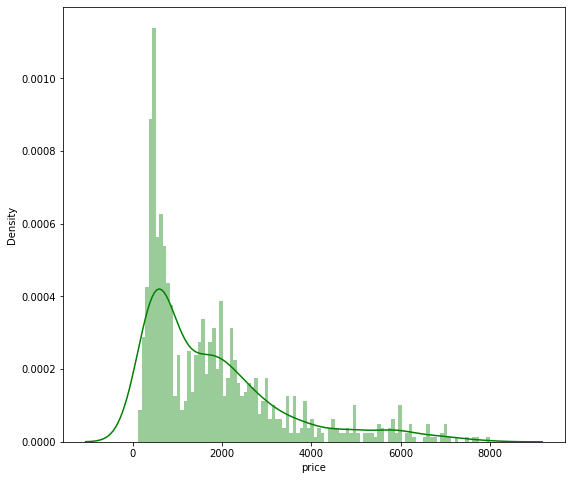

In [37]:
plt.figure(figsize=(9, 8))
sns.distplot(df['price'], color='g', bins=100, hist_kws={'alpha': 0.4})
plt.show()

In [38]:
df['Shoe Type'].value_counts()  # Видим, что мужской обуви сильно больше, чем женской

Men      806
Women    209
Name: Shoe Type, dtype: int64

По ящику с усами видно, что в данных достаточно много выбросов и сами данные растянуты. Мужская обувь по медиане дороже женской, но при этом есть много очень дорогой женской обуви

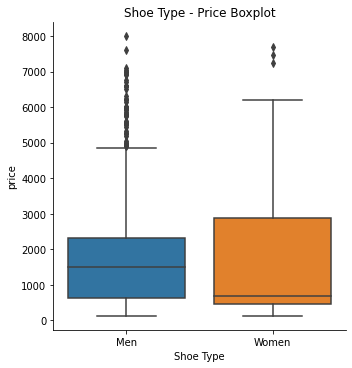

In [39]:
sns.catplot(x="Shoe Type", y="price", data=df, kind="box")
plt.title('Shoe Type - Price Boxplot')
plt.show()

Создадим новый датасет с рейтингом по ревью

In [40]:
reviews = []
for i in df.reviews.to_list():
    for j in i.split('||'):
        reviews.append(j)

rating = []
for i in df.reviews_rating.to_list():
    for j in i.split('||'):
        rating.append(int(j.split()[0][0]))   

In [41]:
df_rev = pd.DataFrame({'review': reviews, 'rating': rating})
df_rev.drop_duplicates(inplace=True)
df_rev

,review,rating
0,Not happy with product,1
1,It's not as expected.,1
2,AVERAGE PRODUCT,3
3,Pic more beautiful,3
4,Got damage product. But quality is average fo...,3
...,...,...
8198,Great shoe,5
8199,excellent quality,5
8200,Old manufactured products being sold.,3
8202,Old stock teared in just 1.5 month of running,1


In [42]:
df_rev = df_rev.drop(df_rev[df_rev.review == ''].index)

По графику видно, что баланса классов нет совершенно, учтем это при создании модели. Также сделаем стратификацию при разбиении выборки на тест и трейн. Интересно, что люди склонны скорее выбирать крайние значения по шкале.

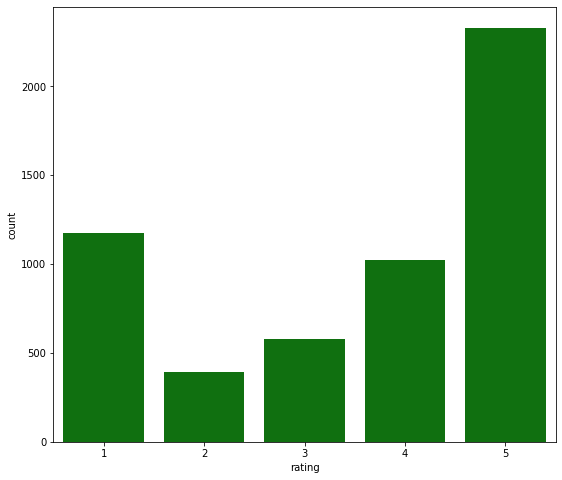

In [43]:
plt.figure(figsize=(9, 8))
sns.countplot(x='rating', data=df_rev, color='g')
plt.show()

## Препроцессинг

2) подготовить данные (стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать... все, что покажется вам разумным относительно данных, но вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг. Хороший препроцессинг - разумный, в данном случае чем больше тем не всегда лучше) 1 балла

In [44]:
! python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

     |████████████████████████████████| 12.0 MB 13.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


Я решила все лемматизировать и убрать стоп-слова, но не убирала пунктуацию, потому что наличие восклицательных знаков – хороший признак для выбирания степени полярности оценки (С восклицательным знаком оценка скорее очень плохая или очень хорошая)

In [45]:
# Spacy убирает проблему слов на другом языке

def preprocess(text, model):
    """
    Function takes text from file,
    deletes all characters that are not letters,
    and transforms words into lowercase lemmas
    joined by whitespace
    """

    docum = nlp(text)
    stop = stopwords.words("english")
    words = ' '.join([w.lemma_.lower() for w in docum if w.lemma_ not in stop])
    return words

In [46]:
df.product_description = df.product_description.apply(lambda x: preprocess(x, nlp))
df_rev.review = df_rev.review.apply(lambda x: preprocess(x, nlp))

In [47]:
df_rev

,review,rating
0,happy product,1
1,-pron- expect .,1
2,average product,3
3,pic beautiful,3
4,got damage product . quality average 300₹,3
...,...,...
8198,great shoe,5
8199,excellent quality,5
8200,old manufactured product sell .,3
8202,old stock tear 1.5 month run,1


# Предсказания

## Классификация

In [48]:
X = df_rev.review.to_list()
y = df_rev.rating.to_list()

In [49]:
vectorizer = TfidfVectorizer()  # Построим TfIdf вектора
X = vectorizer.fit_transform(X).todense()

Сделаем еще одну визуализацию, чтобы посотреть на распределение классов. Видно, что они как-то группируются, но вообще-то простыми прямыми не разделяются

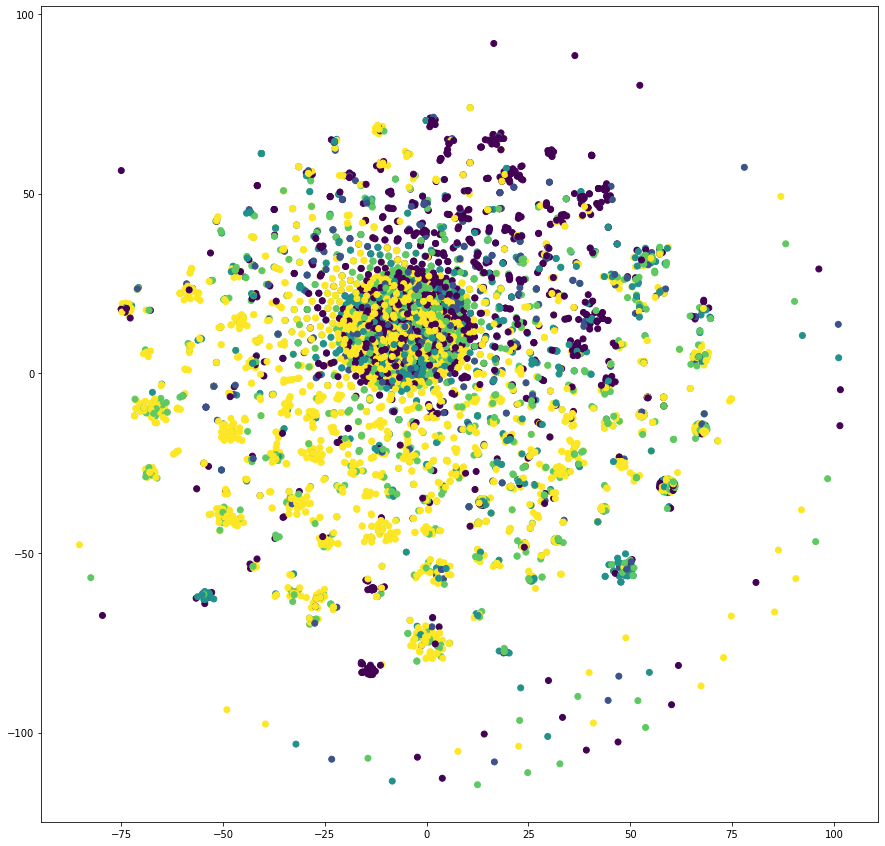

In [50]:
embeddings = TSNE(n_components=2)
Y = embeddings.fit_transform(X)
plt.figure(figsize=(15, 15))
plt.scatter(Y[:, 0], Y[:, 1], c=y)
plt.show()

Проверим качество классификации со стандартизацией. Предварительно кажется, что для текстов стандартизация качество не улучшает.

In [51]:
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42, stratify=y)  # Разобьем на трейн и тест

In [52]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Scaled f1-weighted:", f1_score(y_pred, y_test, average='weighted'))

Scaled f1-weighted: 0.5059651717667032


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)  # Разобьем на трейн и тест

In [54]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Not scaled f1-weighted:", f1_score(y_pred, y_test, average='weighted'))

Not scaled f1-weighted: 0.6204683462650598


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Как и ожидалось, качество лучше без стандартизации, продолжим работать с этими данными

In [55]:
# Словарик моделей и гиперпараметров для грид серча
models = {LogisticRegression(): {'C' : np.logspace(-3, 3, 4)}, 
          KNeighborsClassifier(): {'n_neighbors' : range(5, 30, 10)}, 
          MultinomialNB() : {'alpha': (0.1, 0.5, 1.0)}, 
          LinearSVC() : {'C':np.arange(0.01, 101, 20)}, 
          DecisionTreeClassifier() : {'criterion':['gini','entropy'], 'max_depth':[3, 5, 15, 20, 25]}}

best_f = 0  # Будем искать лучшую модель по взвешенной ф мере
for model in tqdm(models.keys()):
    gs = GridSearchCV(model, param_grid=models[model], 
                      scoring='f1_weighted',
                      n_jobs=-1, cv=10, return_train_score=True)

    gs.fit(X_train, y_train)

    if gs.best_score_ > best_f:
        best_f = gs.best_score_
        best_alg = model
        best_param = gs.best_params_

print()
print("The best algorithm is:", best_alg)
print()
print("Optimal hyperparameter combination:", best_param)
print()
print("Cross-validated training f1 weighted score:",
      best_f)

best_classifier_tfidf = gs.best_estimator_
best_classifier_tfidf.fit(X_train, y_train)
y_pred = best_classifier_tfidf.predict(X_test)
print(classification_report(y_pred, y_test))

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 60%|██████    | 3/5 [22:19<14:00, 420.32s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 5/5 [24:30<00:00, 294.11s/it]



The best algorithm is: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Optimal hyperparameter combination: {'C': 10.0}

Cross-validated training f1 weighted score: 0.4880516277803939
              precision    recall  f1-score   support

           1       0.34      0.64      0.44       154
           2       0.02      0.05      0.03        44
           3       0.10      0.33      0.15        43
           4       0.05      0.25      0.08        48
           5       0.89      0.48      0.62      1085

    accuracy                           0.47      1374
   macro avg       0.28      0.35      0.26      1374
weighted avg       0.75      0.47      0.55      1374



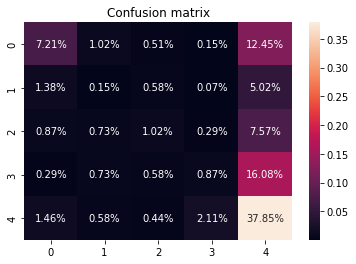

In [56]:
sns.heatmap(confusion_matrix(y_test, y_pred)/np.sum(confusion_matrix(y_test, y_pred)), annot=True, fmt='.2%') 
plt.title("Confusion matrix")
plt.show()

Большинство проблем возникает с 4 классом, то есть с оценкой "5" так как эта оценка самая частотная, модели практически все называют этой оценкой. На classification report видно, что вообще-то точность у маленьких классов очень плохая, а у большого класса отличная, это же отражается и в confusion matrix. Модель не справляется с дисбалансом, нужно отдельным образом продумать штраф за ошибочное присваивание оценки "5". Например, раз наша лучшая модель LogReg – можно установить параметр class_weight

In [57]:
X = df_rev.review.to_list()
y = df_rev.rating.to_list()

In [58]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X).todense()

In [59]:
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42, stratify=y)  # Разобьем на трейн и тест

In [60]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Scaled f1-weighted:", f1_score(y_pred, y_test, average='weighted'))

Scaled f1-weighted: 0.5062681221144517


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)  # Разобьем на трейн и тест

In [62]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Not scaled f1-weighted:", f1_score(y_pred, y_test, average='weighted'))

Not scaled f1-weighted: 0.6006743244817662


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Снова выбираем данные без стандартизации

In [63]:
models = {LogisticRegression(): {'C' : np.logspace(-3, 3, 4)}, 
          KNeighborsClassifier(): {'n_neighbors' : range(5, 30, 10)}, 
          MultinomialNB() : {'alpha': (0.1, 0.5, 1.0)}, 
          LinearSVC() : {'C':np.arange(0.01, 101, 20)}, 
          DecisionTreeClassifier() : {'criterion':['gini','entropy'], 'max_depth':[3, 5, 15, 20, 25]}}

best_f = 0
for model in tqdm(models.keys()):
    gs = GridSearchCV(model, param_grid=models[model], 
                      scoring='f1_weighted',
                      n_jobs=-1, cv=10, return_train_score=True)

    gs.fit(X_train, y_train)

    if gs.best_score_ > best_f:
        best_f = gs.best_score_
        best_alg = model
        best_param = gs.best_params_

print()
print("The best algorithm is:", best_alg)
print()
print("Optimal hyperparameter combination:", best_param)
print()
print("Mean cross-validated training f1 weighted score:",
      best_f)

best_classifier_count = gs.best_estimator_
best_classifier_count.fit(X_train, y_train)
y_pred = best_classifier_count.predict(X_test)
print(classification_report(y_pred, y_test))

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 60%|██████    | 3/5 [22:50<14:21, 430.58s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 5/5 [25:00<00:00, 300.01s/it]



The best algorithm is: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Optimal hyperparameter combination: {'alpha': 0.1}

Mean cross-validated training f1 weighted score: 0.5012831037627525
              precision    recall  f1-score   support

           1       0.34      0.65      0.45       155
           2       0.02      0.18      0.04        11
           3       0.09      0.39      0.15        33
           4       0.09      0.23      0.13        98
           5       0.90      0.49      0.63      1077

    accuracy                           0.48      1374
   macro avg       0.29      0.39      0.28      1374
weighted avg       0.75      0.48      0.56      1374



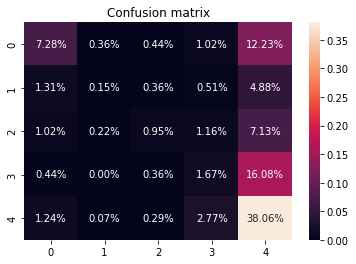

In [64]:
sns.heatmap(confusion_matrix(y_test, y_pred)/np.sum(confusion_matrix(y_test, y_pred)), annot=True, fmt='.2%') 
plt.title("Confusion matrix")
plt.show()

Большинство проблем возникает с 4 классом, то есть с оценкой "5" так как эта оценка самая частотная, модели практически все называют этой оценкой. На classification report видно, что вообще-то точность у маленьких классов очень плохая, а у большого класса отличная, это же отражается и в confusion matrix. Модель не справляется с дисбалансом, нужно отдельным образом продумать штраф за ошибочное присваивание оценки "5". При этом в целом ситуация хуже чем с классификатором на TfIdf, примерно на 10 пунктов по всем классам

## Регрессия

In [17]:
X = df.product_description.to_list()
y = df.price.to_list()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X).todense()

In [18]:
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42)  # Разобьем на трейн и тест

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Scaled MAE:", mean_absolute_error(y_pred, y_test))

Scaled MAE: 1006925387479268.5


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)  # Разобьем на трейн и тест

In [21]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Not scaled MAE:", mean_absolute_error(y_pred, y_test))

Not scaled MAE: 1772098996825576.0


Выбираем стандартизированный вариант

In [22]:
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42)  # Разобьем на трейн и тест

In [23]:
models = {Ridge() : {'alpha':[100, 200, 250, 300]}, 
          SGDRegressor() : {'alpha' : 10.0**-np.arange(1,5),'l1_ratio':[.05, .15, .5, .7, .95, 1]}, 
          LinearSVR() : {'C':[1.5, 3, 4, 10],'epsilon':[0.1,0.2,0.5,0.3]}, 
          LinearRegression() : {}, 
          Lasso() : {'alpha' : np.linspace(0, 0.2, 21)}, 
          ElasticNet() : {"max_iter": [1, 5, 10],
                          "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          "l1_ratio": np.arange(0.0, 1.0, 0.4)}}
best_mae = -100000000000
for model in tqdm(models.keys()):
    gs = GridSearchCV(model, param_grid=models[model], 
                      scoring="neg_mean_absolute_error",
                      n_jobs=-1, cv=10, return_train_score=True)

    gs.fit(X_train, y_train)

    if gs.best_score_ > best_mae:
        best_mae = gs.best_score_
        best_alg = model
        best_param = gs.best_params_

print()
print("The best algorithm is:", best_alg)
print()
print("Optimal hyperparameter combination:", best_param)
print()
print("Mean cross-validated training mae score:",
      best_mae)

best_regressor_tfidf = gs.best_estimator_
best_regressor_tfidf.fit(X_train, y_train)
y_pred = best_regressor_tfidf.predict(X_test)
print()
print("Final MAE:", mean_absolute_error(y_pred, y_test))

 67%|██████▋   | 4/6 [09:31<05:13, 156.66s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10257285.99359639, tolerance: 185805.64072454674
  positive)
 83%|████████▎ | 5/6 [17:50<04:40, 280.17s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154983725.19686604, tolerance: 185805.64072454674
  positive)
100%|██████████| 6/6 [18:25<00:00, 184.26s/it]


The best algorithm is: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Optimal hyperparameter combination: {'alpha': 300}

Mean cross-validated training mae score: -783.3955191896741

Final MAE: 801.2087906741618



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154983725.19686604, tolerance: 185805.64072454674
  positive)


**Посмотрим на самые важные признаки**

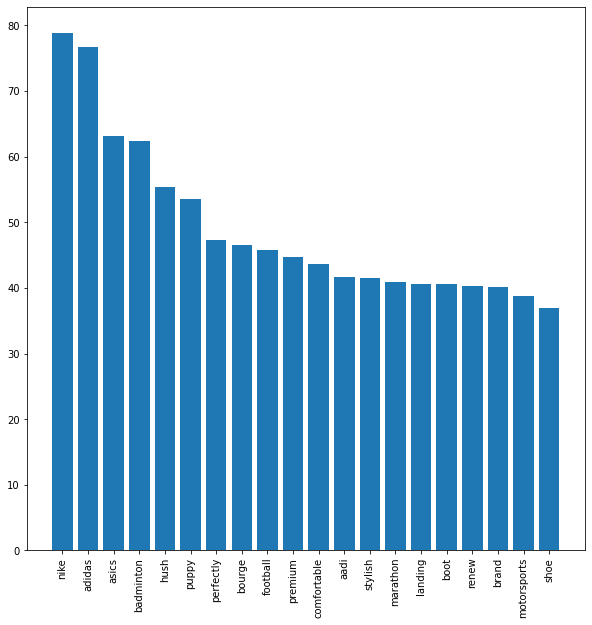

In [24]:
importance = best_regressor_tfidf.coef_
w = vectorizer.get_feature_names()
k = [(i, abs(v)) for i, v in zip(w, importance)]
imp = sorted(k, key=lambda x: x[1], reverse=True)[:20]

plt.figure(figsize=(10, 10))
plt.bar([x[0] for x in imp], [x[1] for x in imp])
plt.xticks(rotation=90)
plt.show()

На предсказание больше всего влияет бренд обуви, рекламные слова (comfortable, advanced, premium) и некоторые свойства спортивной обуви: football, marathon

In [25]:
X = df.product_description.to_list()
y = df.price.to_list()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X).todense()

In [26]:
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42)  # Разобьем на трейн и тест

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Scaled MAE:", mean_absolute_error(y_pred, y_test))

Scaled MAE: 858216052811849.0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)  # Разобьем на трейн и тест

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Not scaled MAE:", mean_absolute_error(y_pred, y_test))

Not scaled MAE: 713801236386651.8


Оставляем вариант без стандартизации

In [30]:
models = {Ridge() : {'alpha':[100, 200, 250, 300]}, 
          SGDRegressor() : {'alpha' : 10.0**-np.arange(1,5),'l1_ratio':[.05, .15, .5, .7, .95, 1]}, 
          LinearSVR() : {'C':[1.5, 3, 4, 10],'epsilon':[0.1,0.2,0.5,0.3]}, 
          LinearRegression() : {}, 
          Lasso() : {'alpha' : np.linspace(0, 0.2, 21)}, 
          ElasticNet() : {"max_iter": [1, 5, 10],
                          "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          "l1_ratio": np.arange(0.0, 1.0, 0.4)}}
best_mae = -100000000000
for model in tqdm(models.keys()):
    gs = GridSearchCV(model, param_grid=models[model], 
                      scoring="neg_mean_absolute_error",
                      n_jobs=-1, cv=10, return_train_score=True)

    gs.fit(X_train, y_train)

    if gs.best_score_ > best_mae:
        best_mae = gs.best_score_
        best_alg = model
        best_param = gs.best_params_

print()
print("The best algorithm is:", best_alg)
print()
print("Optimal hyperparameter combination:", best_param)
print()
print("Mean cross-validated training mae score:",
      best_mae)

best_regressor_count = gs.best_estimator_
best_regressor_count.fit(X_train, y_train)
y_pred = best_regressor_count.predict(X_test)
print()
print("Final MAE:", mean_absolute_error(y_pred, y_test))

 67%|██████▋   | 4/6 [00:49<00:22, 11.23s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22751827.002634086, tolerance: 185805.64072454674
  positive)
 83%|████████▎ | 5/6 [08:07<02:45, 165.27s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284376721.459443, tolerance: 185805.64072454674
  positive)
100%|██████████| 6/6 [08:55<00:00, 89.32s/it] 


The best algorithm is: ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Optimal hyperparameter combination: {'alpha': 0.1, 'l1_ratio': 0.8, 'max_iter': 5}

Mean cross-validated training mae score: -784.9811361162432

Final MAE: 876.2185317415998



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284376721.459443, tolerance: 185805.64072454674
  positive)


**Подсчитаем важность признаков**

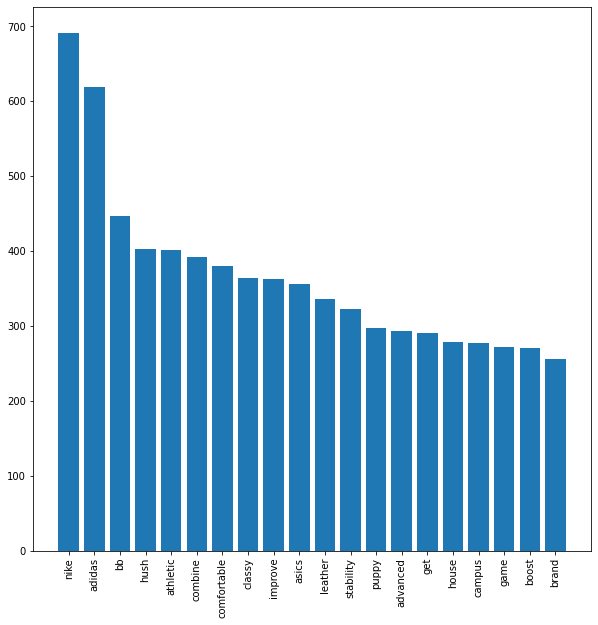

In [31]:
importance = best_regressor_count.coef_
w = vectorizer.get_feature_names()
k = [(i, abs(v)) for i, v in zip(w, importance)]
imp = sorted(k, key=lambda x: x[1], reverse=True)[:20]

plt.figure(figsize=(10, 10))
plt.bar([x[0] for x in imp], [x[1] for x in imp])
plt.xticks(rotation=90)
plt.show()

Видно, что в целом на предсказание больше всего влияет бренд обуви, "рекламные" слова типа comfortable, advanced. Интересно, что этот график соотносится с предыдущим. За комфорт приходится платить(

## Подведение итогов и улучшения



Итого лучшим классификатором стал мультиномиальный наивный баес на векторах CountVectorizer, а лучшим регрессором – ЭластикНет также на векторах TfIdf

Если бы мы брали контекстные модели, то можно было бы векторизовать смайлики с помощью EmojiToVec, кроме того можно было бы посчитать сентимент отзыва как фичу с помощью dostoevsky. Нужно лучше продумать работу с дисбалансом классов.  По-хорошему, мы видели, что мужская и женская обувь стоит по-разному, но так как английские тексты род не отражают, информация о гендере таргетной аудитории и авторах отзывов не попадает в фичи. Стоило бы учитывать признак gender. 